In [184]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import radialProfile
from matplotlib.colors import LogNorm
from tqdm import tqdm_notebook, tnrange, tqdm
from powernoise import powernoise # Stolen from https://gist.github.com/j-faria/7961488
from astropy.modeling import models, fitting

In [142]:
# Generate mock-data - Gaussian!
xsize = 100
ysize = 100
image = np.random.power(5/3-1,size=[ysize, xsize])

In [185]:
# Generate mock-data - Power spectrum!
xsize = 100
ysize = 100
a = -5/3
xmin= 1e-3
kolmo = powernoise(5/3, ysize*xsize, normalize=True)
image = np.reshape(kolmo, [ysize, xsize])

In [186]:
# Take the fourier transform of the image.
F1 = fftpack.fft2(image)
 
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift( F1 )
 
# Calculate a 2D power spectrum
psd2D = np.abs( F2 )**2
 
# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(psd2D)

<IPython.core.display.Javascript object>


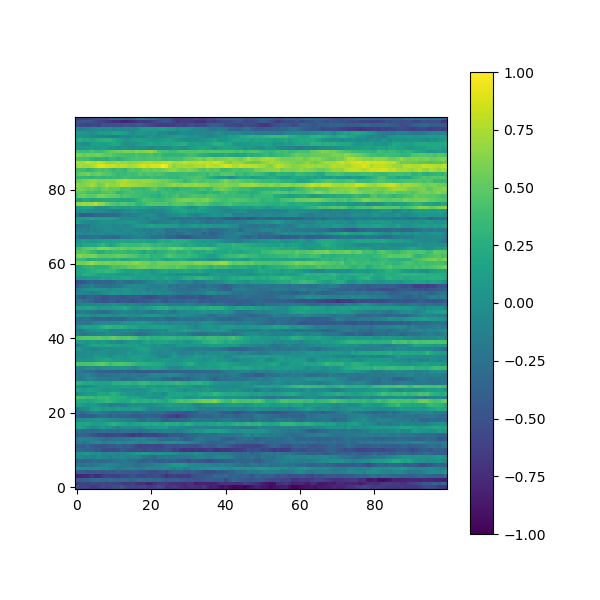

In [187]:
plt.figure()
plt.imshow(image, origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>


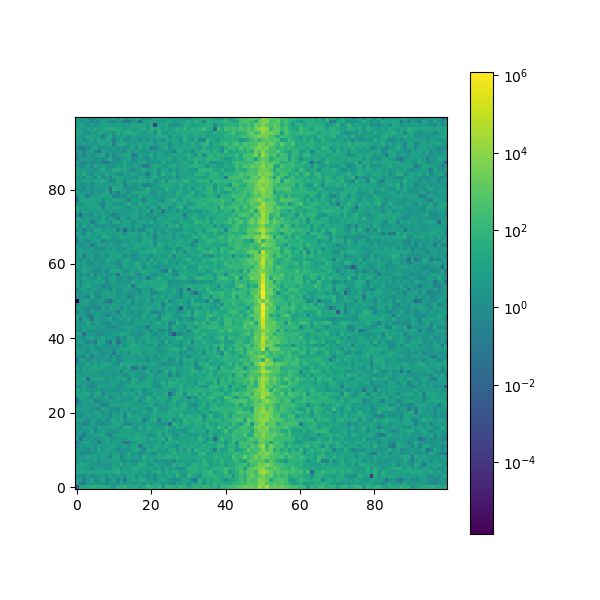

In [188]:
plt.figure()
plt.imshow(psd2D, origin='lower', norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


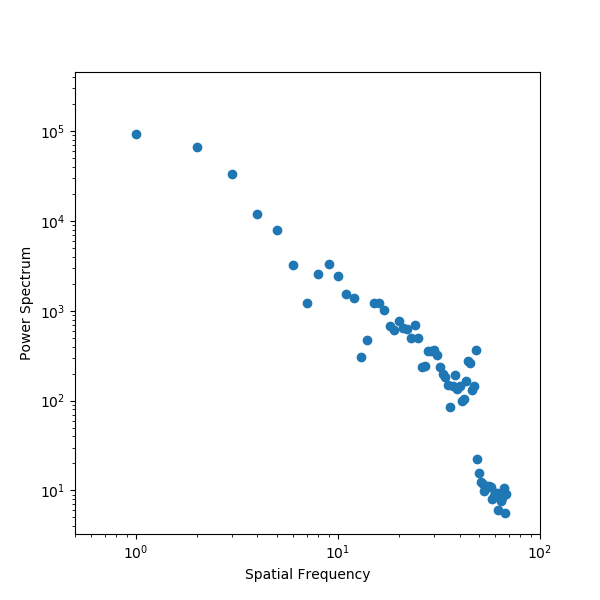

Text(0, 0.5, 'Power Spectrum')

In [189]:
plt.figure()
plt.plot(psd1D,'o')
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-1, 1e2)
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')

In [190]:
# Now lets sample a Gaussian distribution for each pixel
samples = 1000

# I'll just use 1.0 as the standard deviation
error  = np.ones_like(image)*1 # microGauss
samples = 1000
b_dist = np.zeros([samples,ysize,xsize])

# I'm currently using nested for loops...which is bad...
## There should be a way to do this in NumPy, but I'm feeling lazy
for i in tnrange(ysize):
    for j in range(xsize):
        b_dist[:,i,j] = np.random.normal(loc=image[i,j], scale=error[i,j], size=samples)

<IPython.core.display.Javascript object>


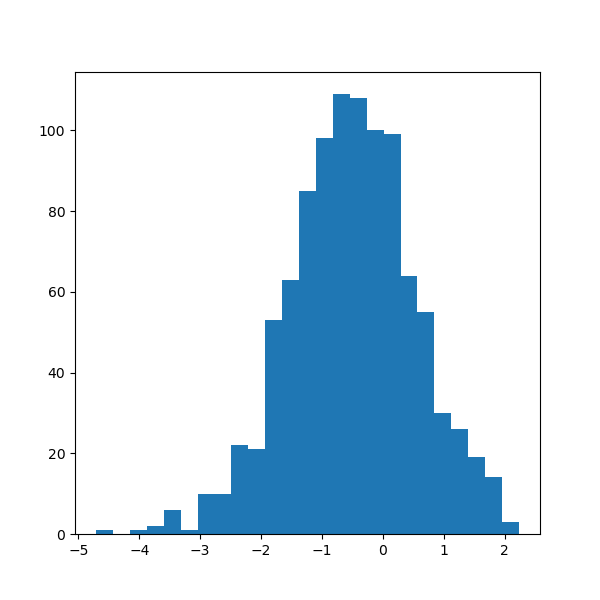

(array([  1.,   0.,   1.,   2.,   6.,   1.,  10.,  10.,  22.,  21.,  53.,
         63.,  85.,  98., 109., 108., 100.,  99.,  64.,  55.,  30.,  26.,
         19.,  14.,   3.]),
 array([-4.70774456, -4.43018401, -4.15262346, -3.87506291, -3.59750236,
        -3.31994181, -3.04238126, -2.76482071, -2.48726016, -2.20969961,
        -1.93213906, -1.6545785 , -1.37701795, -1.0994574 , -0.82189685,
        -0.5443363 , -0.26677575,  0.0107848 ,  0.28834535,  0.5659059 ,
         0.84346645,  1.121027  ,  1.39858755,  1.6761481 ,  1.95370866,
         2.23126921]),
 <a list of 25 Patch objects>)

In [191]:
# Lets look at the histogram of the first pixel
plt.figure()
plt.hist(b_dist[:,0,0], bins=25)

In [192]:
# Take the fourier transform of the image.
#psd2D_dist = np.zeros_like(b_dist)
#for i in tnrange(samples):
F1_dist = fftpack.fft2(b_dist)

# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2_dist = fftpack.fftshift( F1_dist )
# Calculate a 2D power spectrum
psd2D_dist = np.abs( F2_dist )**2

In [193]:
# Calculate the azimuthally averaged 1D power spectrum
## Currently doing this as a loop, but could be fixed in 'radialProfile.py' to use NumPy. This 
## would be much faster!
psd1D_dist = []
for i in tnrange(psd2D_dist.shape[0]):
    psd1D_dist.append(radialProfile.azimuthalAverage(psd2D_dist[i]))
psd1D_dist = np.array(psd1D_dist)

<IPython.core.display.Javascript object>


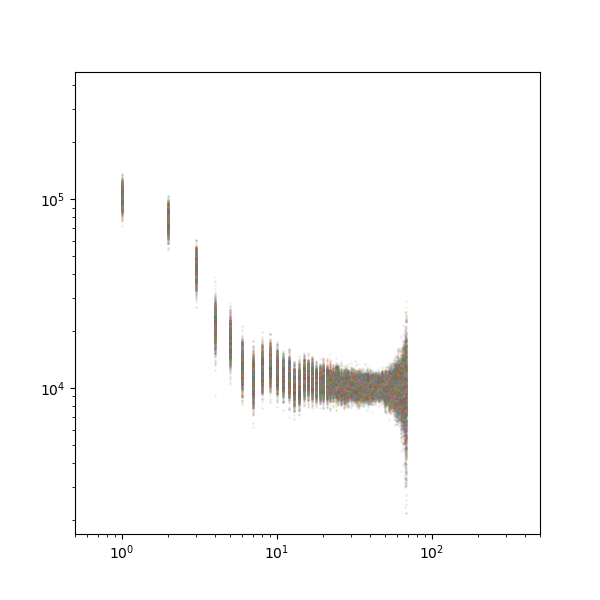

(0.5, 500.0)

In [194]:
# Now we have MANY samples! Lets see how they all look!
plt.figure()
for i in tnrange(psd1D_dist.shape[0]):
    plt.plot(psd1D_dist[i], 'o', markersize=1, alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-1, 5e2)

In [195]:
# Now lets use the median and percentiles of these spectra
psd1D_med = np.nanmedian(psd1D_dist, axis=0)
psd1D_p16 = np.nanpercentile(psd1D_dist, 16, axis=0)
psd1D_p84 = np.nanpercentile(psd1D_dist, 84, axis=0)

psd1D_err_plus = psd1D_p84 - psd1D_med
psd1D_err_minus = psd1D_med - psd1D_p16

<IPython.core.display.Javascript object>


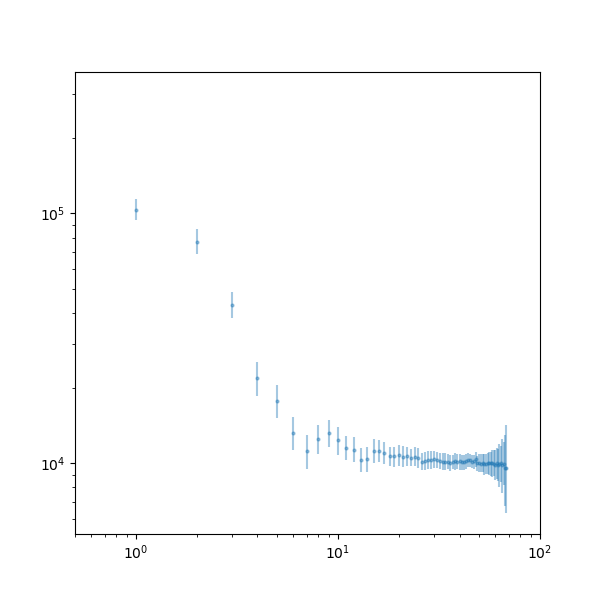

(0.5, 100.0)

In [196]:
# Lets plot it! First using error bars
plt.figure()
plt.errorbar(np.arange(len(psd1D_med)), psd1D_med, yerr=[psd1D_err_minus, psd1D_err_plus],  \
             fmt='o', ms=2, alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-1, 1e2)

<IPython.core.display.Javascript object>


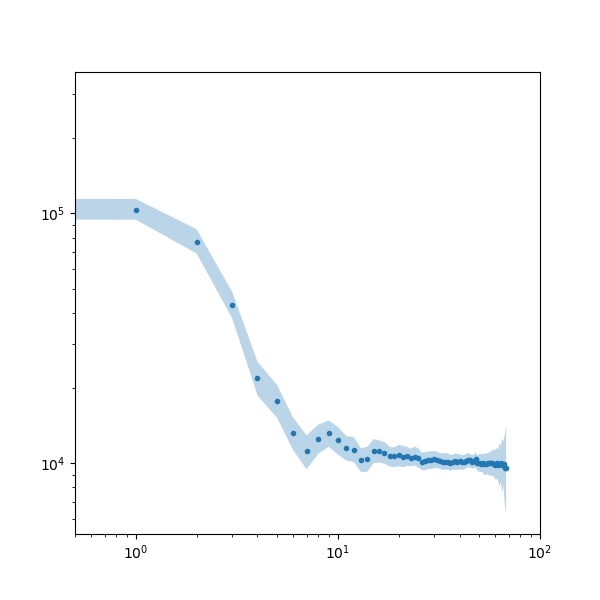

(0.5, 100.0)

In [197]:
# Lets try with fill_between
plt.figure()
plt.plot(psd1D_med, 'o', markersize=3)
plt.fill_between(np.arange(len(psd1D_med)), psd1D_p16, psd1D_p84, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e-1, 1e2)